# Исследование данных о поездках сервиса GoFast

Задача:

Имеются данные популярного сервиса аренды самокатов GoFast: о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проаназировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**без подписки**

абонентская плата отсутствует;

стоимость одной минуты поездки — 8 рублей;

стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**

абонентская плата — 199 рублей в месяц;

стоимость одной минуты поездки — 6 рублей;

стоимость старта — бесплатно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math

#### Шаг 1. Загрузка данных

In [2]:
try:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
except:
    data_users = pd.read_csv('/datasets/users_go.csv')
    
try:
    data_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
except:
    data_rides = pd.read_csv('/datasets/rides_go.csv')

try:
    data_sscr = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
except:
    data_sscr = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# ознакомление с ДФ
def df_info(name_df):
    display(name_df.head())
    display(name_df.info())
    display(name_df.isna().sum())


In [4]:
df_info(data_users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

**Таблица с информацией по пользователям**

**user_id** - уникальный идентификатор пользователя

**name** - имя пользователя

**age** - возраст

**city** - город

**subscription_type** - тип подписки (free, ultra)

Пропусков в данных нет.

In [5]:
df_info(data_rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

user_id     0
distance    0
duration    0
date        0
dtype: int64

**Таблица с информацией по поездкам**

**user_id** - уникальный идентификатор пользователя

**distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)

**duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

**date** - дата совершения поездки

Пропусков в данных нет. В столбце date необходимо изменить тип данных на дату.

In [6]:
df_info(data_sscr)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Таблица с информацией о подписке**
**subscription_type** - тип подписки

**minute_price** - стоимость одной минуты поездки по данной подписке

**start_ride_price** - стоимость начала поездки

**subscription_fee** - стоимость ежемесячного платежа

Пропусков в данных нет. 0 - значит, что стоимость нулевая.

#### Шаг 2. Предобработка данных

In [7]:
# приведем столбец date к формату даты:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')


In [8]:
# проверим, за какой период предоставлены данные
data_rides['date'].dt.year.unique()


array([2021], dtype=int64)

Данные предоставлены за один год, 2021

In [9]:
# добавим столбец с месяцем
data_rides['month'] = data_rides['date'].dt.month


In [10]:
# проверяем дубликаты
print('Количество дубликатов в таблице с пользователями:', data_users.duplicated().sum())
print('Количество дубликатов в таблице с поездками: ', data_rides.duplicated().sum())
print('Количество дубликатов в таблице с подписками: ', data_sscr.duplicated().sum())

Количество дубликатов в таблице с пользователями: 31
Количество дубликатов в таблице с поездками:  0
Количество дубликатов в таблице с подписками:  0


In [11]:
# удаляем дубликаты
data_users = data_users.drop_duplicates()
data_users = data_users.reset_index(drop=True)
print('Количество дубликатов в таблице с пользователями после обработки:', data_users.duplicated().sum())

Количество дубликатов в таблице с пользователями после обработки: 0


In [12]:
# проверяем уникальность id:
display(len(data_users['user_id']))
display(data_users['user_id'].nunique())

1534

1534

In [13]:
# проверяем уникальность городов:
display(data_users['city'].nunique())
display(data_users['city'].str.upper().nunique())

8

8

In [14]:
# проверяем уникальные значения типа подписки
data_users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

**Выводы по разделу 2** 

Провели предобработку данных:

1. Привели столбец date к формату даты.
2. Добавили столбец с месяцем month.
3. Удалили дубликаты в таблице с пользователями.
4. Проверили уникальность значений среди ид пользователей, городов и типа подписки. Данные в порядке, замены не требуется.

#### Шаг 3. Исследовательский анализ данных

Медиана: 191.0


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

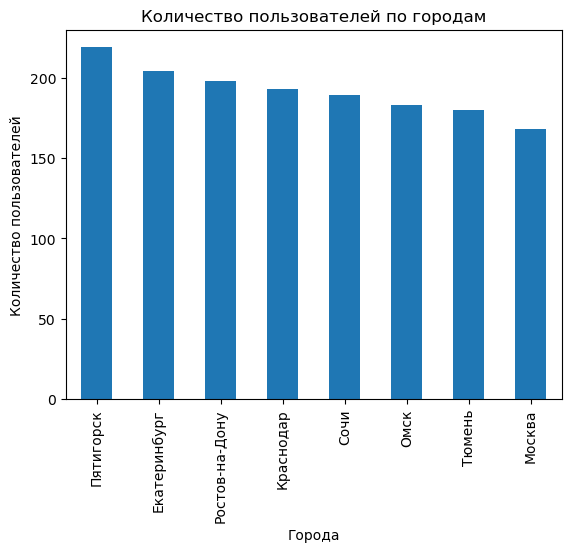

In [15]:
# частота встречаемости городов
data_users['city'].value_counts().plot(kind='bar');
plt.title('Количество пользователей по городам');
plt.xlabel("Города");
plt.ylabel("Количество пользователей"); 
print('Медиана:', data_users['city'].value_counts().median())
data_users['city'].value_counts()

Наибольшую популярность аренда самокатов имеет в Пятигорске - там 219 пользователей. Наименьшую - в Москве, 168 пользователей.

Медианное значение равно 191 и число пользователей по остальным городам близко к этому значению.

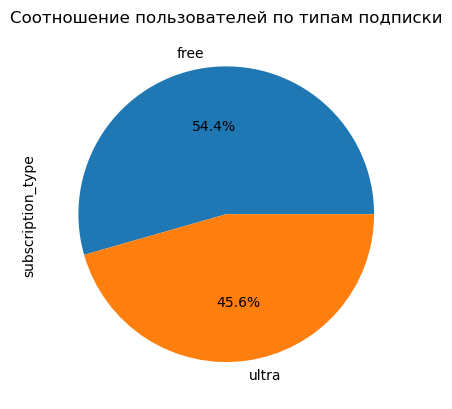

In [16]:
# соотношение пользователей с подпиской и без подписки
data_users['subscription_type'].value_counts().plot(kind='pie', autopct='%.1f%%');
plt.title('Соотношение пользователей по типам подписки');


Пользователи по типам подписки разделились примерно поровну, но все же без подписки их больше - 54.4% против 45.6%

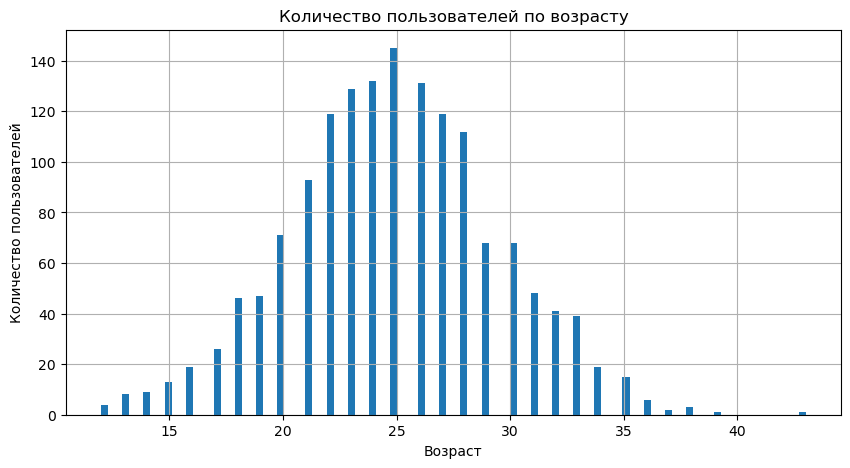

In [17]:
# возраст пользователей
data_users['age'].hist (bins= 100, figsize = (10,5));
plt.title('Количество пользователей по возрасту');
plt.xlabel("Возраст");
plt.ylabel("Количество пользователей");

Больше всего популярны самокаты среди 25-летних, а большинство значений приходится на интервал от 18 до 33 лет.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

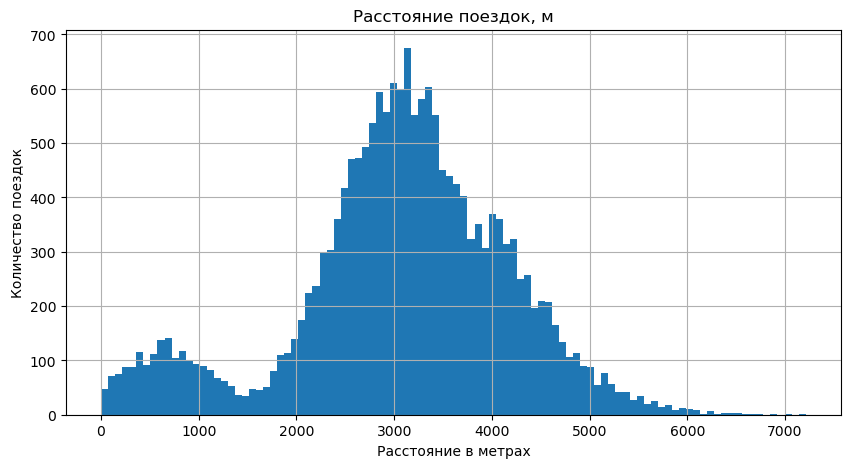

In [18]:
# расстояние, которое пользователь преодолел за одну поездку
data_rides['distance'].hist(bins=100, figsize = (10,5))
plt.title('Расстояние поездок, м');
plt.xlabel("Расстояние в метрах");
plt.ylabel("Количество поездок");
data_rides['distance'].describe()

In [19]:
data_rides.query('distance < 400')['distance'].count()

424

In [20]:
data_rides.query('distance > 5000')['distance'].count()

541

Сильных выбросов нет. Значения менее 400 метров и более 5 километров довольно редки и выглядят как эскперименты пользователей.

Среднее и медианное значения по длине поездки близки друг к другу, поэтому можно сказать, что самокат в среднем арендуют, чтобы проехать около 3 км.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

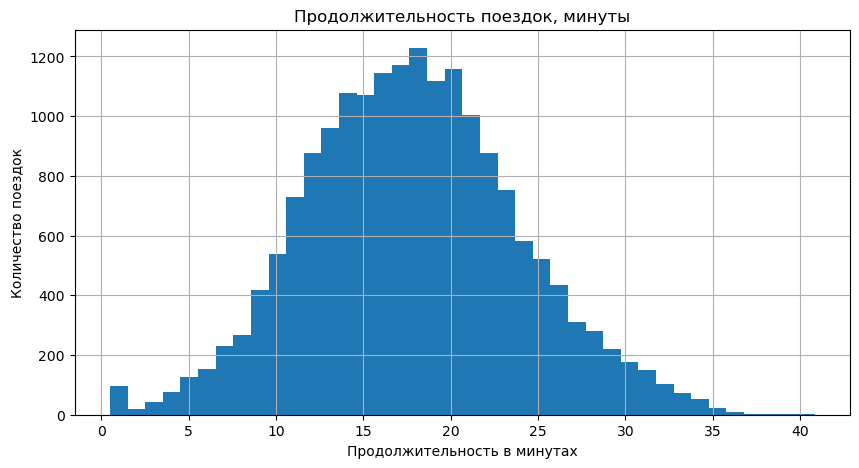

In [21]:
# продолжительность поездок
data_rides['duration'].hist(bins=40, figsize = (10,5))
plt.title('Продолжительность поездок, минуты');
plt.xlabel("Продолжительность в минутах");
plt.ylabel("Количество поездок");
data_rides['duration'].describe()

In [22]:
data_rides.query('duration <= 6')['distance'].count()

421

Данные по продолжительности поездки соответствуют данным по расстоянию. Средняя поездка занимает 17-18 минут, так что при скорости 10,5 км/час пользователь проедет 3 км. 

Короткие по расстоянию поездки, которые мы сочли экспериментальными, по времени могли занять не меньше 6 минут. Не у всех пользователей получилось покататься, хотя они долго пытались!

**Выводы по разделу 3** 
1. Большинство пользователей самокатов находится в Пятигорске (219), меньше всего их в Москве (168). В среднем по городам 191 пользователь.

2. Пользователей без подписки - 54.4%, с подпиской - 45,6%.

3. Пользуется сервисом в основном молодежь от 18 до 33 лет, пик приходится на 25 лет.

4. В среднем самокат арендуют на 17-18 минут, чтобы проехать около 3 км.



#### Шаг 4. Объединение данных

In [23]:
#  объединим данные о пользователях, поездках и подписках в один датафрейм
data_total = data_users.merge(data_rides, on='user_id', how='left')
data_total = data_total.merge(data_sscr, on='subscription_type', how='left', indicator=True)

# проверим, все ли строки попали в финальную таблицу
display(len(data_total))
display(len(data_rides))

data_total.sort_values(by='_merge')

18068

18068

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,_merge
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,both
12036,1104,Ольга,24,Краснодар,free,2767.373507,15.547382,2021-11-09,11,8,50,0,both
12037,1104,Ольга,24,Краснодар,free,3871.834746,15.615504,2021-11-14,11,8,50,0,both
12038,1105,Богдан,22,Пятигорск,free,3295.364742,12.061496,2021-01-09,1,8,50,0,both
12039,1105,Богдан,22,Пятигорск,free,3232.037291,19.120140,2021-02-24,2,8,50,0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6020,645,Олеся,36,Краснодар,ultra,2556.430106,25.338581,2021-05-06,5,6,0,199,both
6019,645,Олеся,36,Краснодар,ultra,2559.843612,10.143625,2021-01-25,1,6,0,199,both
6018,645,Олеся,36,Краснодар,ultra,955.930910,7.294234,2021-01-18,1,6,0,199,both
6024,645,Олеся,36,Краснодар,ultra,2807.733574,18.657455,2021-07-19,7,6,0,199,both


In [24]:
# датафрейм c данными о пользователях без подписки
data_sscr_on = data_total.loc[data_total['subscription_type'] == 'ultra']
display(data_sscr_on.head())
# датафрейм с данными о пользователях с подпиской
data_sscr_off = data_total.loc[data_total['subscription_type'] == 'free']
display(data_sscr_off.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,_merge
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,both
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,both
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,both
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,both
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,both


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,_merge
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0,both
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0,both
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0,both
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0,both
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0,both


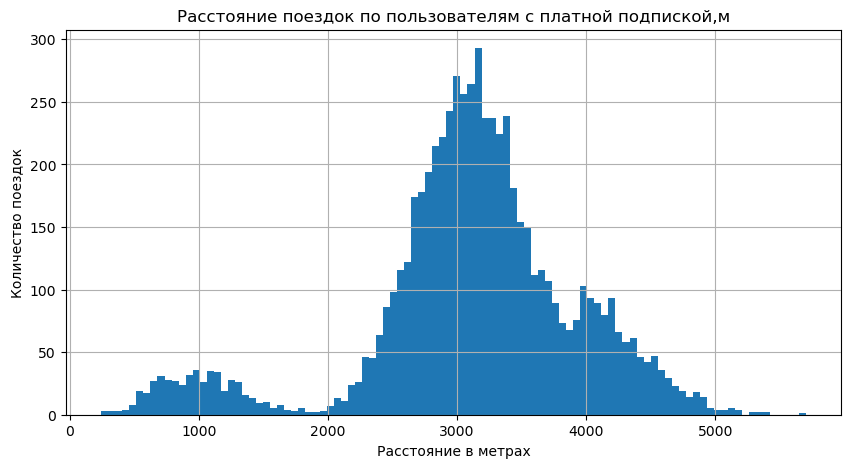

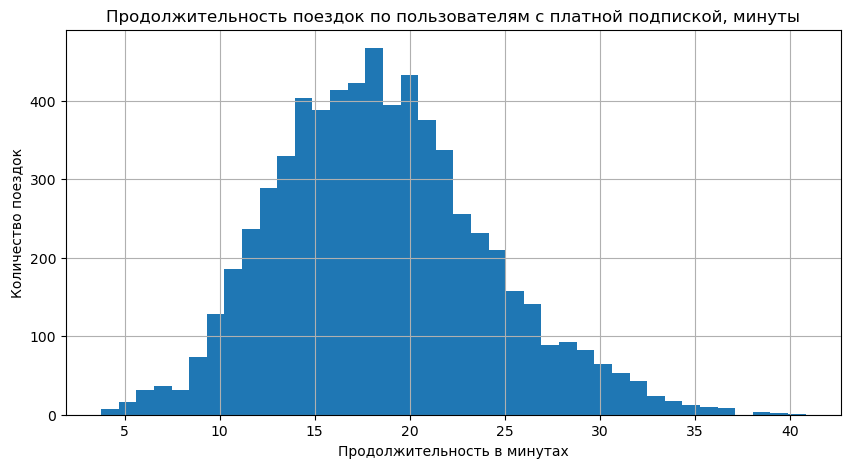

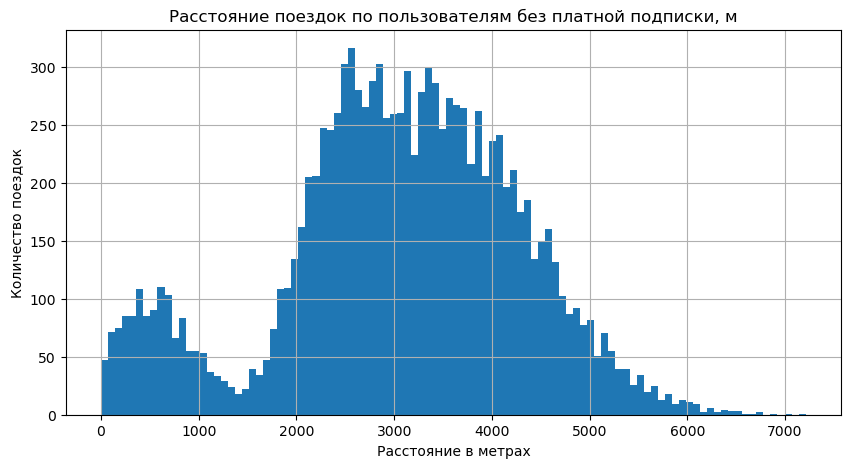

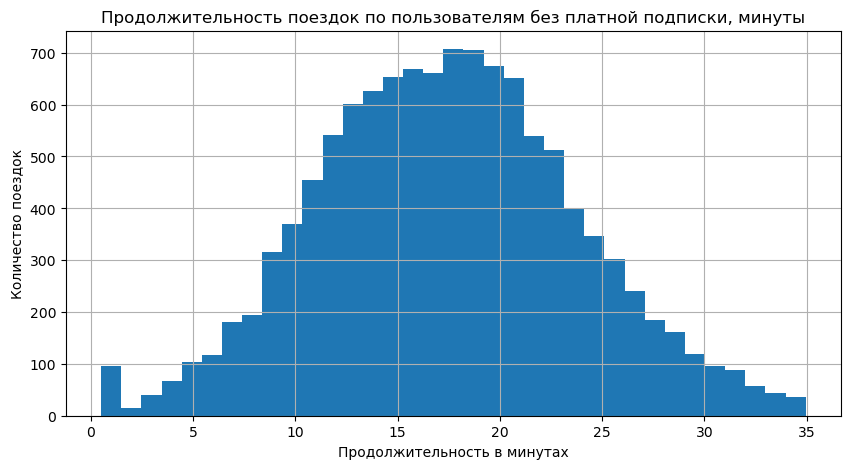

In [25]:
# визуализируем информацию о расстоянии и времени поездок для пользователей с разным типом подписки
data_sscr_on['distance'].hist(bins=100, figsize = (10,5))
plt.title('Расстояние поездок по пользователям с платной подпиской,м');
plt.xlabel("Расстояние в метрах");
plt.ylabel("Количество поездок");
plt.show()
data_sscr_on['duration'].hist(bins=40, figsize = (10,5))
plt.title('Продолжительность поездок по пользователям с платной подпиской, минуты');
plt.xlabel("Продолжительность в минутах");
plt.ylabel("Количество поездок");
plt.show()
 
data_sscr_off['distance'].hist(bins=100, figsize = (10,5))
plt.title('Расстояние поездок по пользователям без платной подписки, м');
plt.xlabel("Расстояние в метрах");
plt.ylabel("Количество поездок");
plt.show()
data_sscr_off['duration'].hist(bins=35, figsize = (10,5))
plt.title('Продолжительность поездок по пользователям без платной подписки, минуты');
plt.xlabel("Продолжительность в минутах");
plt.ylabel("Количество поездок");
plt.show()

Графики расстояния и времени поездки с разделением по типу подписки в целом повторяют общую картину. Большинство поездок совершается в интервале 2,5-3,5 км за 15-20 минут.

Но есть и различия:

Пользователи с подпиской ездят по привычным маршрутам. Для кого-то они составялют 1 км, но в среднем это 3 км за 18 минут.

Пользователи без подписки много экспериментируют. Почти сотня поездок длилась минуту, за которую проезжали не больше пары сотен метров. И большинство поездок дальше 5 км также принадлежит эскпериментаторам из free-подписки.


**Выводы по разделу 4**

1. Объединили данные о пользователях, поездках и подписках в один датафрейм data_total.
2. Создали ещё два датафрейма из ДФ data_total:
- c данными о пользователях без подписки data_sscr_off;
- с данными о пользователях с подпиской data_sscr_on.
3. Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий:
- Пользователи с платной подпиской пользуются самокатами в качестве транспорта, чтобы добраться по привычныму маршруту, который в среднем составляет 3 км, но также есть пики в районе 1 км и 4км.
- Пользватели без платной подписки в среднем тоже используют самокаты на поездки такой длины и продолжительности, хоть и с большим разбросом, но также совершают пробные поездки на малые (менее 1 км) и дальние (больше 5,5 км) расстояния. Логичный вывод - люди сначала тестируют сервис, прежде чем оформить платную подписку.


#### Шаг 5. Подсчёт выручки

In [26]:
# создадим ДФ, в который добавим суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
data_revenue = (data_total.groupby(['user_id', 'month'])
                .agg({'distance':['count','sum'], 'duration':['sum']})
                .reset_index()
               )
data_revenue.columns = ['user_id', 'month', 'trips', 'distance_sum', 'duration_sum']

data_revenue['subscription_type'] = data_total['subscription_type']

data_revenue

,user_id,month,trips,distance_sum,duration_sum,subscription_type
0,1,1,2,7027.511294,41.416640,ultra
1,1,4,1,754.159807,6.232113,ultra
2,1,8,2,6723.470560,44.776802,ultra
3,1,10,2,5809.911100,31.578017,ultra
4,1,11,3,7003.499363,53.397424,ultra
...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,24.812678,free
11327,1534,8,2,7622.453034,47.205960,free
11328,1534,9,1,4928.173852,22.560373,free
11329,1534,11,4,13350.015305,76.342174,free


In [27]:
data_sscr

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [28]:
# добавим столбец с помесячной выручкой, которую принёс каждый пользователь

def revenue_monthly(data_revenue):
    if data_revenue['subscription_type'] == 'free':
        rev  = (np.ceil(data_revenue['duration_sum']) * data_sscr.loc[0, 'minute_price']
         + data_sscr.loc[0, 'start_ride_price'] * data_revenue['trips']
         + data_sscr.loc[0, 'subscription_fee'])
    elif data_revenue['subscription_type'] == 'ultra':
        rev  = (np.ceil(data_revenue['duration_sum']) * data_sscr.loc[1, 'minute_price'] 
         + data_sscr.loc[1, 'start_ride_price']  * data_revenue['trips']
         + data_sscr.loc[1, 'subscription_fee'])
    return rev
        

data_revenue['revenue'] = data_revenue.apply(revenue_monthly, axis=1)
data_revenue

,user_id,month,trips,distance_sum,duration_sum,subscription_type,revenue
0,1,1,2,7027.511294,41.416640,ultra,451.0
1,1,4,1,754.159807,6.232113,ultra,241.0
2,1,8,2,6723.470560,44.776802,ultra,469.0
3,1,10,2,5809.911100,31.578017,ultra,391.0
4,1,11,3,7003.499363,53.397424,ultra,523.0
...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,24.812678,free,300.0
11327,1534,8,2,7622.453034,47.205960,free,484.0
11328,1534,9,1,4928.173852,22.560373,free,234.0
11329,1534,11,4,13350.015305,76.342174,free,816.0


**Выводы по разделу 5:**

Создали датафрейм data_revenue со столбцами:
- ид пользователя user_id 
- разбивка по месяцам month
- количество поездок trips
- расстояние в разрезе пользователей по месяцам distance_sum
- продолжительность поездок в разрезе пользователей по месяцам duration_sum
- тип подписки subscription_type
- помесячная выручка в разрезе пользователей revenue

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.


##### 
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. 

In [29]:
# нулевая гипотеза: пользователи с подпиской тратят столько же времени на поездки, как и люди без подписки
# альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки, чем люди без подписки

alpha = 0.05
 
results = st.ttest_ind(data_sscr_on['duration'], data_sscr_off['duration'], alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу.


Вывод: гипотетически, пользователи с подпиской потратят больше времени на поездки, чем люди без подписки.

##### 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу.

In [30]:
# нулевая гипотеза: пользователи с подпиской за одну поездку проезжают расстояние, которое равно 3130 метрам
# альтернативная гипотеза: пользователи с подпиской за одну поездку проезжают расстояние, которое не превышает 3130 метров
optimal_distance = 3130
 
alpha = 0.05
 
results = st.ttest_1samp(
    data_sscr_on['distance'],
    optimal_distance,
    alternative='less')
 
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


Вывод: согласно гипотезе, пользователи с подпиской проедут за одну поездку проедут не менее 3130 метров. Однако р-значение лишь 8%, значит, гипотеза приближалась к альтернативной. 

##### 

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [31]:
# нулевая гипотеза: помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки
# альтернативная гипотеза: помесячная выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки
ultra = data_revenue.query('subscription_type == "ultra"')
free = data_revenue.query('subscription_type == "free"')
alpha = 0.05
results = st.ttest_ind(ultra['revenue'],free['revenue'], equal_var=False, alternative = 'greater')
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 7.151717626168935e-48
Отвергаем нулевую гипотезу


Вывод: гипотетически, пользователи с подпиской принесут больше выручки сервису, чем пользователи без подписки.

##### 

ВОПРОС:
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

ОТВЕТ:
В данном случае выборки будут парными, так как переменная "количество обращений в техподдержку" измеряется дважды для одних и тех же объектов до и после обновления сервера. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяется метод scipy.stats.ttest_rel().

**Выводы по разделу 6:**

Согласно гипотезам, пользователи с платной подпиской тратят больше времени на поездки и приносят больше выручки в месяц, чем пользователи без подписки.

А вот соблюсти износостойкость самокатов вряд ли получится за счет подписки - подписанты вероятно проедут не меньше 3130 метров.


#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [32]:
#from scipy.stats import poisson
from scipy.stats import binom

p = 0.1
threshold = 100 
n = 0
#lmbd = p*n
prob = 1 - st.binom.cdf(threshold, n, p)

for c in range(0, 100000):
    if prob < 0.95:
        n += c
        #lmbd = p*n
        prob = 1 - st.binom.cdf(threshold, n, p)
n


1176

In [33]:
1 - st.binom.cdf(100, 1172, 0.1)

0.9504520478979693

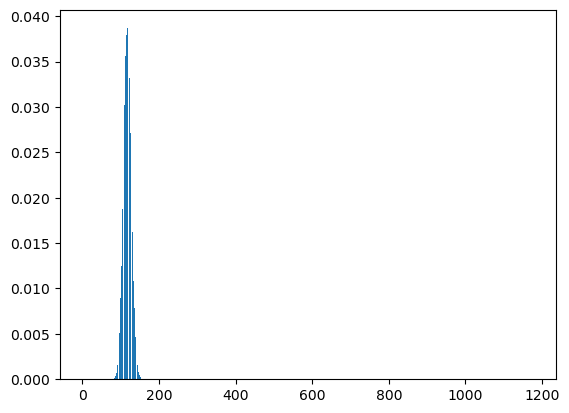

In [34]:
#from math import factorial
from scipy.stats import binom

p = 0.1 # вероятность, что подписку продлят
n = 1176 # сколько промокодов с бесплатной подпиской

distr = [] 

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    #choose = factorial(n) / (factorial(k) * factorial(n - k))
    #prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(current_value)
     

plt.bar(range(0, n + 1), distr);

Чтобы с вероятностью 5% получить 100 продлений подписки, нужно раздать не менее 861 промокода.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 
40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

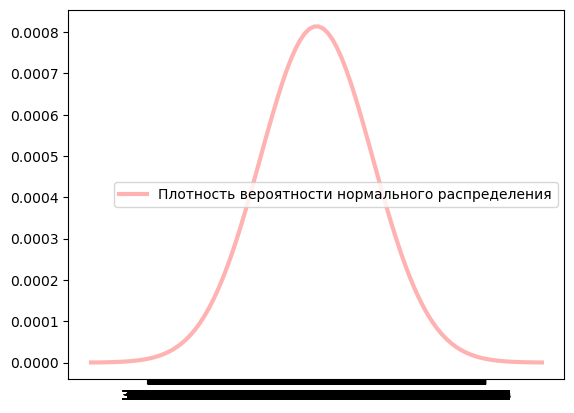

0.15371708296369768


In [36]:
from math import sqrt
from scipy import stats as st
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

n = 1000000 
p = 0.4

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right))
ax = plt.subplot()

mu = n * p  
sigma = sqrt(n * p * (1 - p)) 

mu = n * p
sigma = sqrt(n * p * (1 - p))
x = linspace(left, right, 100)
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='Плотность вероятности нормального распределения')
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)
ax.legend(loc='best')
plt.show()
        
        
        
distr = st.norm(mu, sigma)

result = distr.cdf(399500)
print(result)


Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, равна 15.4%

**Общий вывод:**

1. Пропусков в данных не было.
2. В предобработке данных заменили тип в столбце date на дату, добавили столбец с месяцем month, удалили дубликаты в таблице с пользователями.
3. В исследовательском анализе данных выяснили, что:
- Большинство пользователей самокатов находится в Пятигорске (219), меньше всего их в Москве (168). В среднем по городам 191 пользователь.

- Пользователей без подписки - 54.4%, с подпиской - 45,6%.

- Пользуется сервисом в основном молодежь от 18 до 33 лет, пик приходится на 25 лет.

- В среднем самокат арендуют на 17-18 минут, чтобы проехать около 3 км.

4. Проверили гипотезы, не отвергнуты:
- Пользователи с подпиской потратят больше времени на поездки, чем люди без подписки.
- Пользователи с подпиской проедут за одну поездку проедут не менее 3130 метров.
- Пользователи с подпиской принесут больше выручки сервису, чем пользователи без подписки.

5. Посчитали с помощью распределений для отдела маркетинга:
- Чтобы с вероятностью 5% получить 100 продлений подписки, нужно раздать не менее 861 промокода на 1 месяц бесплатной подписки.
- Вероятность того, что push-уведомление в мобильном приложении откроют не более 399,5 тыс. пользователей из 1 млн, равна 15.4%